# WebGL Viz of OpenStreetMap and OpenChargeMap

Requires the following to be installed:
```
pip install jinja2 matplotlib osmnx pandas

brew tap neomantra/homebrew-tap
brew install neomantra/homebrew-tap/go-openchargemap
```

In [1]:
# Set up parameters
ocm_key = 'insert your OpenChargeMap KEY' # see the README about this

root_address = '362 Memorial Dr, Cambridge, MA'
root_dist = 1500 # meters

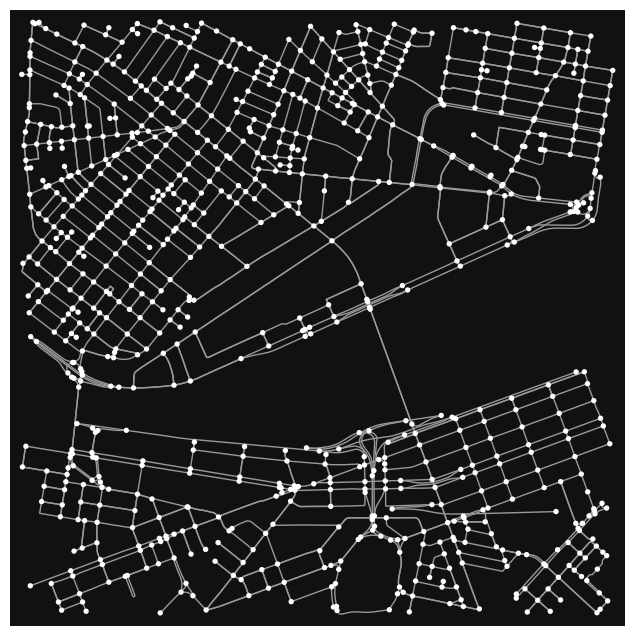

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# Ask OpenStreetMap for the Map Graph of the given address
import osmnx as ox
import matplotlib

G = ox.graph_from_address(root_address, network_type='drive', dist=root_dist)
ox.plot_graph(G)

In [3]:
# Convert the Graph Network into GeoDataFrames
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)

# Extract the bounding box
# chargemeup wants "(40.63010790372053,-74.2775717248681),(40.7356464076158,-74.09370618215354)"
bounds = gdf_nodes.total_bounds
bounds_txt="(%f,%f),(%f,%f)" % (bounds[1], bounds[0], bounds[3], bounds[2])
bounds_txt

'(42.343186,-71.114017),(42.370132,-71.077560)'

In [4]:
# Runs the external chargemeup command with your OCM key and the bounding box.
!chargemeup -k "$ocm_key" -b "$bounds_txt" | tee chargers.json

[{"AddressInfo":{"AccessComments":"24 hours daily","AddressLine1":"245 First Street","ContactTelephone1":"800-663-5633","Country":{"ContinentCode":"NA","ID":2,"ISOCode":"US","Title":"United States"},"CountryID":2,"DistanceUnit":0,"ID":247673,"Latitude":42.363518,"Longitude":-71.079025,"Postcode":"02142","RelatedURL":"http://www.blinkcharging.com/","StateOrProvince":"MA","Title":"Cambridge Science Center","Town":"Cambridge"},"Connections":[{"Amps":16,"Comments":"kW power is an estimate based on the connection type","ConnectionType":{"FormalName":"SAE J1772-2009","ID":1,"Title":"Type 1 (J1772)"},"ConnectionTypeID":1,"CurrentType":{"ID":10,"Title":"AC (Single-Phase)"},"CurrentTypeID":10,"ID":413661,"Level":{"Comments":"Over 2 kW, usually non-domestic socket type","ID":2,"IsFastChargeCapable":false,"Title":"Level 2 : Medium (Over 2kW)"},"LevelID":2,"PowerKW":3.7,"Quantity":4,"Voltage":230}],"DataProvider":{"DataProviderStatusType":{"ID":20,"IsProviderEnabled":true},"DateLastImported":"2023

You can now go open the resultant [chargers.json](./chargers.json) file. If you are interested...

In [5]:
# Generate Markers for the chargers
import pandas as pd
chargers_df = pd.read_json('chargers.json')

charge_markers = []
for i, ch in chargers_df.iterrows():
    addr = ch['AddressInfo']
    marker = {
        'latitude': addr['Latitude'],
        'longitude': addr['Longitude'],
    }
    if 'AddressLine1' in addr:
        marker['addr'] = addr['AddressLine1']
    numConns = 0
    for conn in ch['Connections']:
        if 'Quantity' in conn:
            numConns += conn['Quantity']
    marker['numConns'] = numConns
    charge_markers.append(marker)
charge_markers[0:2]

[{'latitude': 42.363518,
  'longitude': -71.079025,
  'addr': '245 First Street',
  'numConns': 4},
 {'latitude': 42.361618,
  'longitude': -71.081245,
  'addr': '1 Memorial Dr',
  'numConns': 4}]

In [6]:
# Template the HTML file
from jinja2 import Environment, FileSystemLoader, select_autoescape
jenv = Environment(loader=FileSystemLoader("./templates"), autoescape=select_autoescape())

temp = jenv.get_template('index.3d.html.j2')
centerX, centerY = (bounds[0] + (bounds[2]-bounds[0])/2), (bounds[1] + (bounds[3] - bounds[1])/2)
temp_out = temp.render(rootCenterLat=centerX, rootCenterLon=centerY, markers=charge_markers)

with open('./index.3d.html', 'w+') as f:
    f.write(temp_out)

## Viewing the Data in 3D Web Browser

Now you can open the resultant [index.3d.html](./index.3d.html).   If you click that link, VScode will take you to the HTML file.  

If you install the [VSCode Live Preview](https://marketplace.visualstudio.com/items?itemName=ms-vscode.live-server) extension, you will be able to click the `Preview` tool in the upper-right corner; you can also right-click on `examples/index.3d.html` in the File Explorer and select `Show Preview`.  Pretty cool, huh?  =)

Here's some known issues, both due to OSMBuildings not being updated in four years:
 * [ ] the color of the markers is not working
 * [ ] the tile loading is not working because the MapBox tiles use an obsolete API

We'll have to fork and improve OSMBuildings, or otherwise try to use MapBox or someething else.  This was a [great spike](https://qarea.com/blog/what-is-a-spike-in-software-development)!


# VR Experience of the Data 

You can view this data on an Apple Vision Pro. The concept probably also works on Meta Quest 3 or other VR headsets, but have no experience there.

The [VSCode Live Preview](https://marketplace.visualstudio.com/items?itemName=ms-vscode.live-server) starts up a webserver on your computer.  This webserver should work on Linux, Windows, and Mac.   By default it served on port `3000`, so a URL like so http://127.0.0.1:3000/examples/index.3d.html

For other VR device to reach it, you need to expose the webserver to the network.  You can change this at the VSCode Setting `livePreview.hostIP`.  So go to `Extensions`, search for `Live Preview`, click the gear and select `Extension Settings`.  Then find `Host IP` and change it to your computer's IP.

Then on your VR device, navigate to `http://<ipaddress>:3000/examples/index.3d.html` and you should be able to see the 3D map in VR.  You can walk around and see the buildings and chargers.

I like to use [TailScale](https://tailscale.com), so I exposed my TailNet IP address there.   Then I installed TailScale on my Apple Vision Pro, joined my TailNet, then browsed to the above URL on the TailNet^1.  TailScale made it easier to find that server on a network anywhere with my VR device.   

Unfortunately the viewer is not stereoscopic, but I sure was hooting and hollering when I first experienced this!